# Environment setup

In [1]:
!pip install vaderSentiment
!pip install ekphrasis
!pip install tweet-preprocessor

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pprint import pprint
from datetime import datetime
import collections
import sklearn.preprocessing

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import json
from collections import Counter
import re, string, unicodedata

import preprocessor as p

from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## The Dataset

In [3]:
#stock_data
!wget https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/stock_data.csv -O stock_data.csv

#ticker name dataset
!wget https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/ticker_names.csv -O ticker_names.csv

#labeled twitter data
!wget https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/tweets_labelled_09042020_16072020.csv -O tweets_labelled_09042020_16072020.csv

--2021-06-04 03:54:33--  https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/stock_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121430 (119K) [text/plain]
Saving to: ‘stock_data.csv’

stock_data.csv      100%[===================>] 118.58K  --.-KB/s    in 0.04s   

2021-06-04 03:54:33 (3.10 MB/s) - ‘stock_data.csv’ saved [121430/121430]

--2021-06-04 03:54:33--  https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/ticker_names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1286 (1.3K) [text/plain]


In [4]:
#labeled twitter data
!wget https://github.com/jfritsche1/cs247/blob/main/Data/tweets_remaining_09042020_16072020.zip?raw=true -O tweets_remaining_09042020_16072020.zip

--2021-06-04 03:54:34--  https://github.com/jfritsche1/cs247/blob/main/Data/tweets_remaining_09042020_16072020.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jfritsche1/cs247/raw/main/Data/tweets_remaining_09042020_16072020.zip [following]
--2021-06-04 03:54:34--  https://github.com/jfritsche1/cs247/raw/main/Data/tweets_remaining_09042020_16072020.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/tweets_remaining_09042020_16072020.zip [following]
--2021-06-04 03:54:34--  https://raw.githubusercontent.com/jfritsche1/cs247/main/Data/tweets_remaining_09042020_16072020.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [5]:
!unzip tweets_remaining_09042020_16072020.zip 

Archive:  tweets_remaining_09042020_16072020.zip
replace tweets_remaining_09042020_16072020.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tweets_remaining_09042020_16072020.csv  


# Stock Data

In [6]:
stock_data = pd.read_csv('stock_data.csv')
print (stock_data.head(5))

ticker_names = pd.read_csv('ticker_names.csv')
print (ticker_names.head(5))


        Date Ticker        Open  ...       Close   Adj Close    Volume
0   4/9/2020   AAPL  268.700012  ...  267.989990  267.266510  40529100
1  4/13/2020   AAPL  268.309998  ...  273.250000  272.512329  32755700
2  4/14/2020   AAPL  280.000000  ...  287.049988  286.275055  48748700
3  4/15/2020   AAPL  282.399994  ...  284.429993  283.662140  32788600
4  4/16/2020   AAPL  287.380005  ...  286.690002  285.916046  39281300

[5 rows x 8 columns]
  Symbol                           Name Stock       Category Country
0   AAPL                     Apple Inc.   NMS     Technology     USA
1   AMZN               Amazon.com, Inc.   NMS     E-commerce     USA
2    BAC    Bank of America Corporation   NYQ      Financial     USA
3  BRK.B        Berkshire Hathaway Inc.   NYQ          Other     USA
4  CMCSA  Comcast Corporation A. Shares   NMS  Entertainment     USA


In [7]:
grouped = DataFrame(ticker_names.groupby('Category').agg({'Symbol':lambda x: list(x)}))
print(grouped)
df_grouped=grouped.copy()
df_grouped = df_grouped.reset_index(col_level=0)
categories = df_grouped.set_index('Category').T.to_dict('records')[0]

                                            Symbol
Category                                          
Beverages - Soft Drinks                  [KO, PEP]
Drug Manufacturers                 [JNJ, MRK, PFE]
E-commerce                                  [AMZN]
Entertainment                         [CMCSA, DIS]
Financial                        [BAC, JPM, MA, V]
Health Care Plans                            [UNH]
Home Improvement Stores                       [HD]
Internet Information Providers          [FB, GOOG]
Major Integrated Oil & Gas              [CVX, XOM]
Other                                      [BRK.B]
Personal Products                             [PG]
Technology                      [AAPL, INTC, MSFT]
Telecom Services                           [T, VZ]


In [8]:
#We will use Adjusted Closing Price for the analysis
#Adjusted closing price is the closing price after adjustments for all applicable splits and dividend distributions.

tickers = ticker_names.set_index('Symbol').T.to_dict('records')[0]
for key,value in tickers.items():
  data = stock_data[stock_data['Ticker'] == key]
  print("Adjusted Closing Price for ", value)
  print(data['Adj Close'].describe())
  print("*"*50)

Adjusted Closing Price for  Apple Inc.
count     68.000000
mean     325.984285
std       35.629063
min      267.266510
25%      295.819221
50%      319.060013
75%      354.940002
max      390.899994
Name: Adj Close, dtype: float64
**************************************************
Adjusted Closing Price for  Amazon.com, Inc.
count      68.000000
mean     2557.144865
std       259.048332
min      2042.760010
25%      2378.707580
50%      2465.820069
75%      2683.502441
max      3200.000000
Name: Adj Close, dtype: float64
**************************************************
Adjusted Closing Price for  Bank of America Corporation
count    68.000000
mean     23.751131
std       1.637756
min      20.725460
25%      22.726504
50%      23.692272
75%      24.672930
max      28.540001
Name: Adj Close, dtype: float64
**************************************************
Adjusted Closing Price for  Berkshire Hathaway Inc.
count     68.000000
mean     182.771030
std        7.116623
min      169.250000

## Add ADX to Stock Data

In [9]:
# Adapted from https://medium.com/codex/algorithmic-trading-with-average-directional-index-in-python-2b5a20ecf06a
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

In [10]:
stock_data['plus_di'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[0]).rename(columns = {0:'plus_di'})
stock_data['minus_di'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[1]).rename(columns = {0:'minus_di'})
stock_data['adx'] = pd.DataFrame(get_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], 14)[2]).rename(columns = {0:'adx'})

stock_data = stock_data.dropna()

## Visualize Stock Data

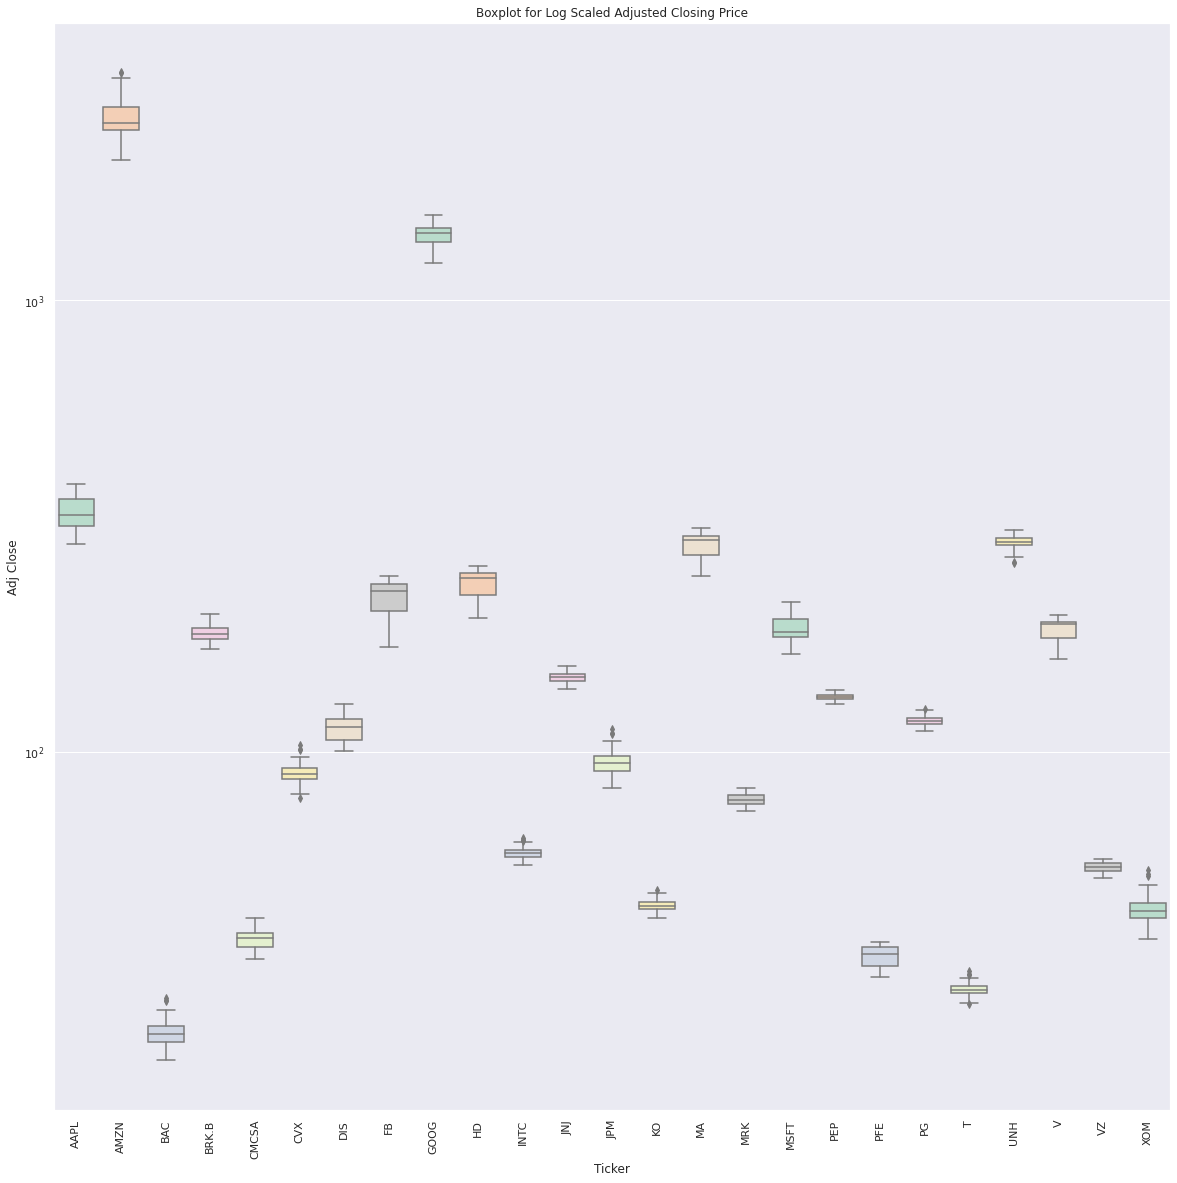

In [11]:
#Since price for Amazon stock and Google stock are much higher, the plots are shown on Log Scale so we can visualize all in one plot
#Boxplot for Log Scaled Adjusted Closing Price"
sns.set(rc={'figure.figsize':(20,20)})
ax = sns.boxplot(x="Ticker", y="Adj Close", data=stock_data, palette='Pastel2')
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Boxplot for Log Scaled Adjusted Closing Price")
  
None

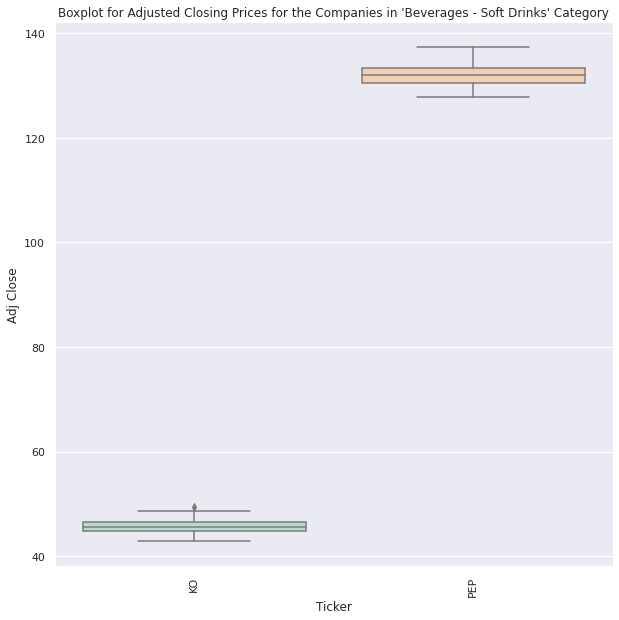

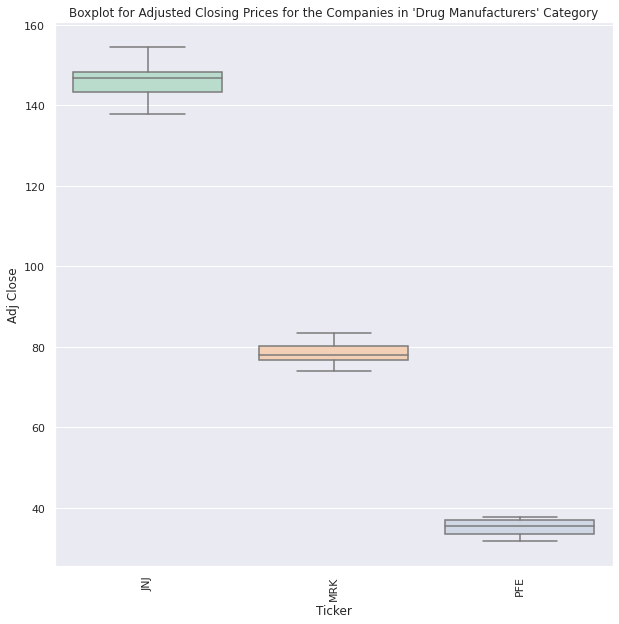

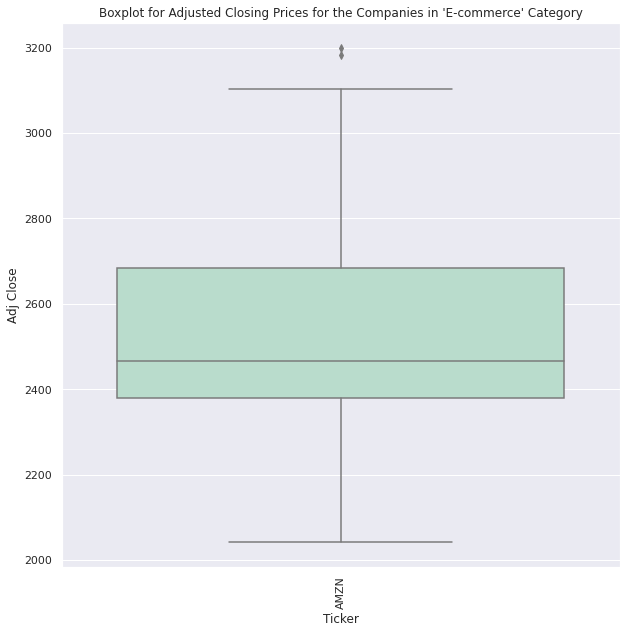

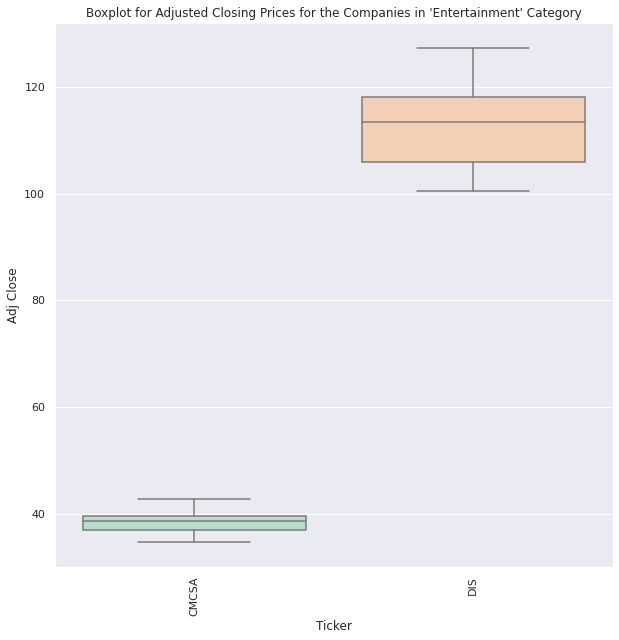

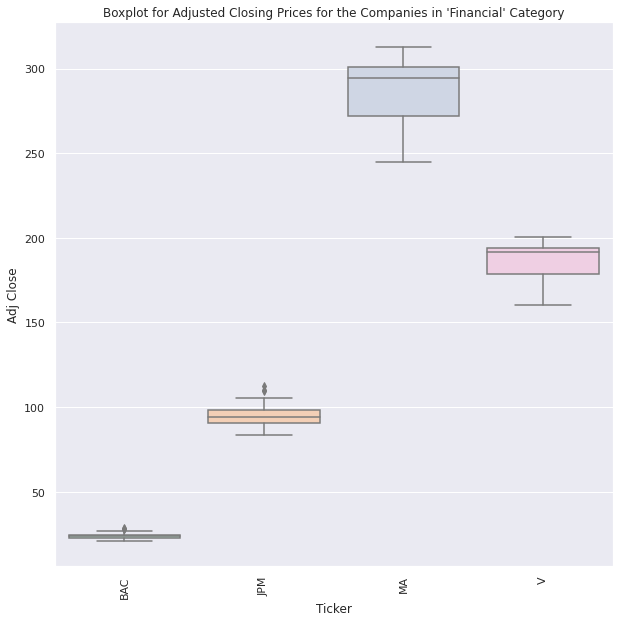

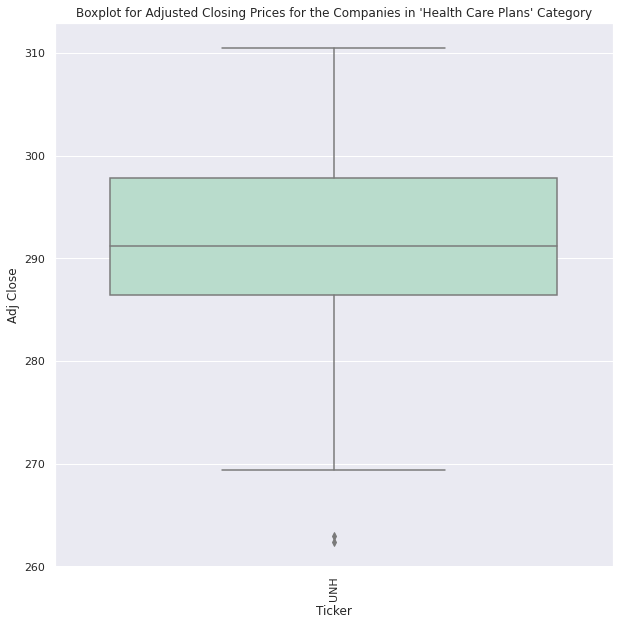

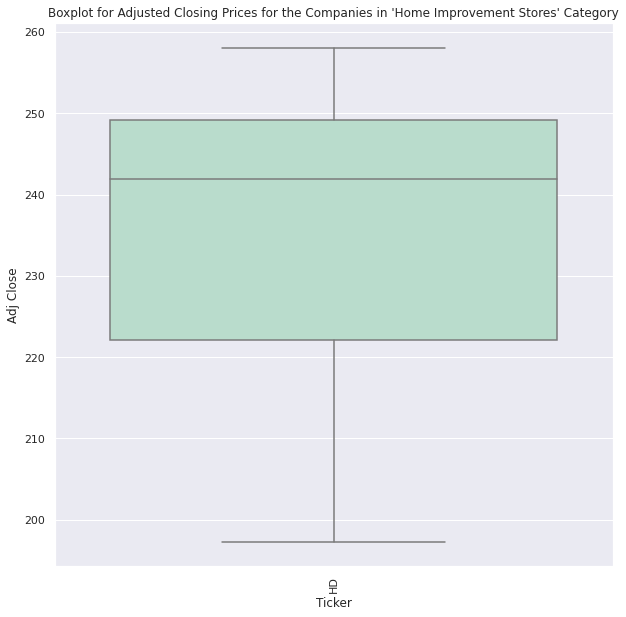

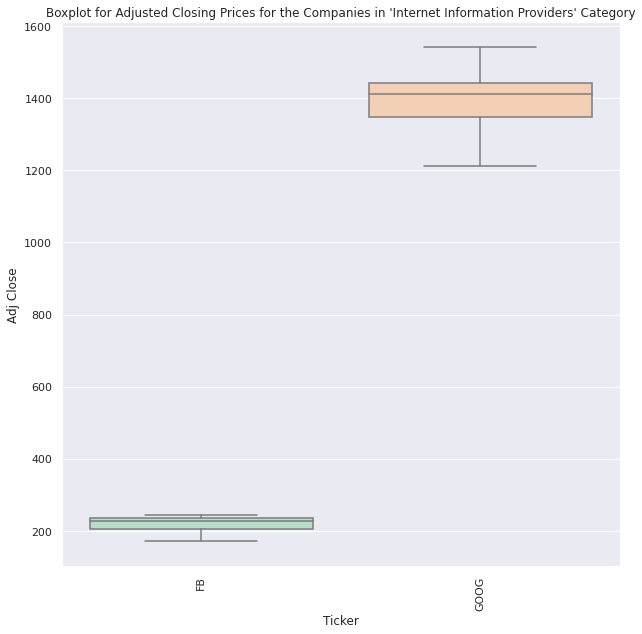

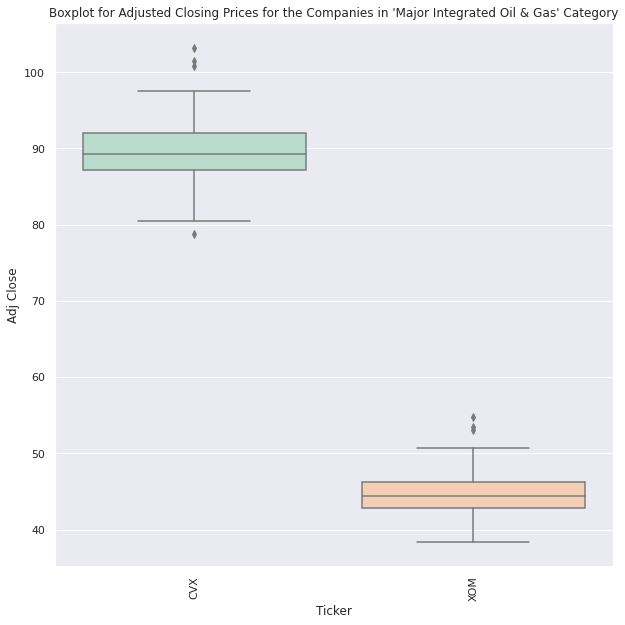

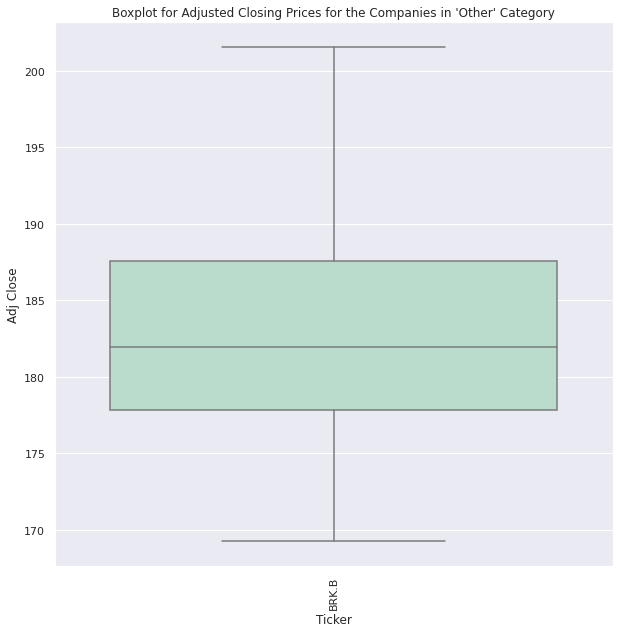

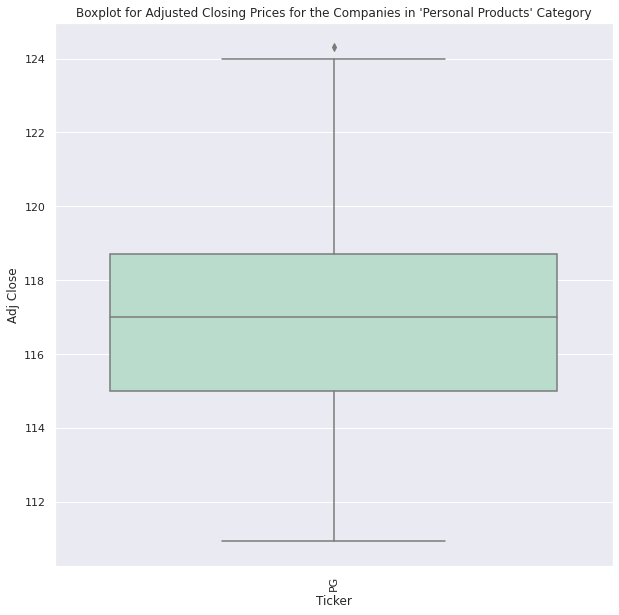

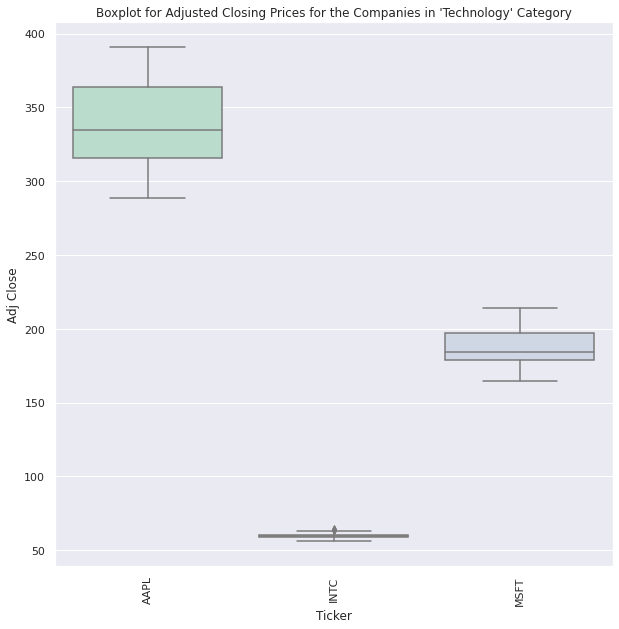

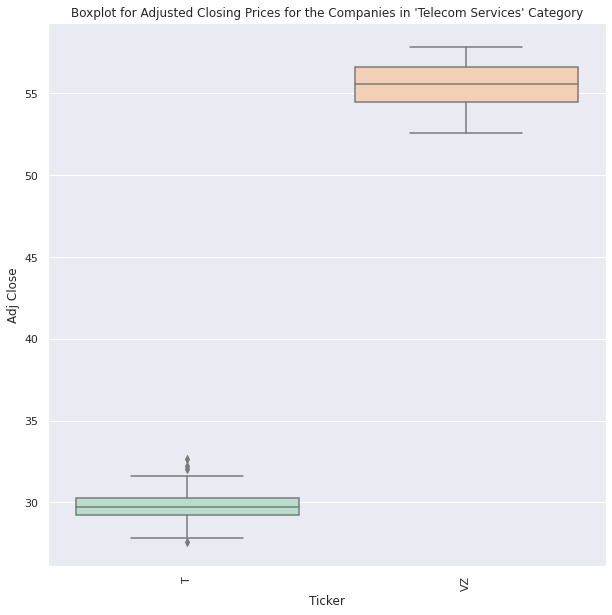

In [12]:
#Now we look at the boxplots of adjusted closing price for companites in each category separately
#Log scale is not applied here, so we can see the actual price.
for key,value in categories.items():
  data = stock_data[stock_data["Ticker"].isin(value)]
  sns.set(rc={'figure.figsize':(10,10)})
  ax = sns.boxplot(x="Ticker", y="Adj Close", data=data, palette='Pastel2')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.title("Boxplot for Adjusted Closing Prices for the Companies in '" + key + "' Category")
  plt.show()
  print('\n')
  None
  

### Plot Stock Data with ADX

In [13]:
def plot_stock(data, ticker):
    sns.set(rc={'figure.figsize':(17,5)})
    ax = sns.lineplot(data=data, x="Date", y="Adj Close", color = 'cornflowerblue')
    ax = sns.lineplot(data=data, x="Date", y="High", color='mediumpurple')
    ax = sns.lineplot(data=data, x="Date", y="Low", color = "lightgreen")
    ax.set(xlabel='Date', ylabel='Stock Price')
    plt.setp(ax.get_xticklabels(), rotation=80)
    plt.title(tickers[ticker])
    plt.legend(["Adj Closing Price", "Highest Price", "Lowest Price"], loc ="lower right")
    plt.show()
    print("\n")

def plot_adx(data,ticker):
  sns.set(rc={'figure.figsize':(17,5)})
  ax = sns.lineplot(data=data, x="Date", y="Adj Close", color = 'cornflowerblue')
  ax = sns.lineplot(data=data, x="Date", y="High", color='mediumpurple')
  ax = sns.lineplot(data=data, x="Date", y="Low", color = "lightgreen")
  plt.legend(["Adj Closing Price", "Highest Price", "Lowest Price"], loc ="lower right")
  
  ax2 = ax.twinx()
  ax2 = sns.lineplot(data=data, x="Date", y="adx", color='#2196f3')
  ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')

  ax.set(xlabel='Date', ylabel='Stock Price')
  plt.setp(ax.get_xticklabels(), rotation=80)
  plt.title(tickers[ticker])
  plt.legend(["ADX"], loc ="upper left")
  plt.show()
  print("\n")

def plot_stock_categories(sData, categories):
  for key,value in categories.items():
    print("*"*130)
    print(""," "*52, "Category - " , key)
    print("*"*130)
    for ticker in value:
      data = sData[sData['Ticker'] == ticker]
      plot_stock(data, ticker)

**********************************************************************************************************************************
                                                      Category -  Beverages - Soft Drinks
**********************************************************************************************************************************


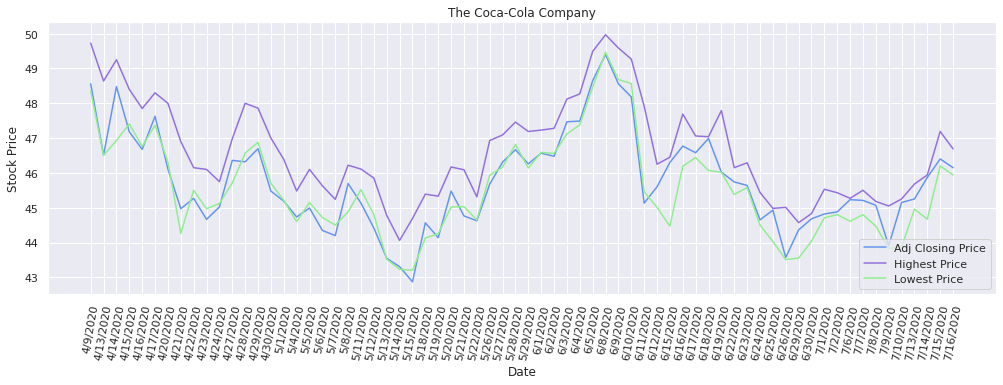

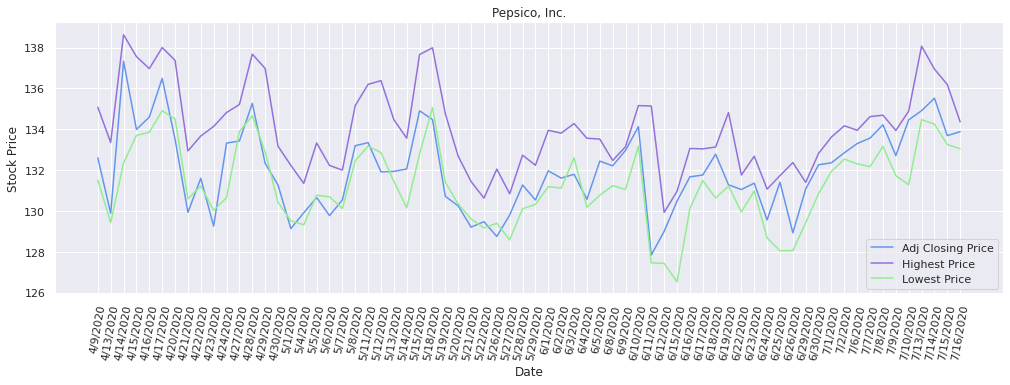



**********************************************************************************************************************************
                                                      Category -  Drug Manufacturers
**********************************************************************************************************************************


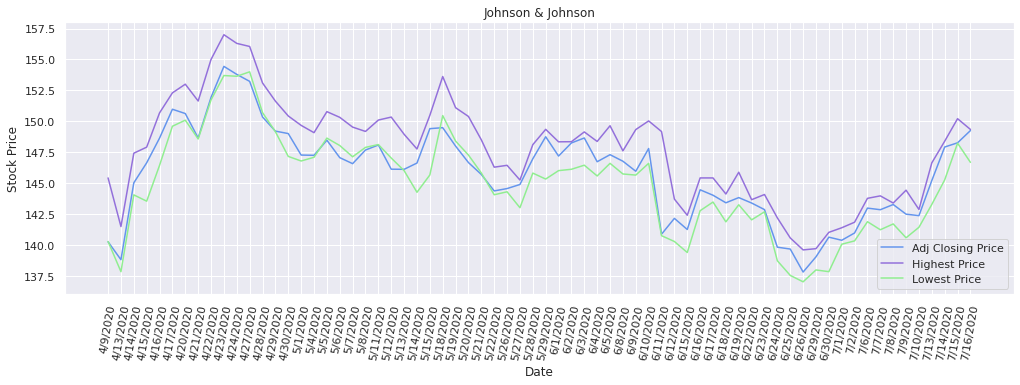

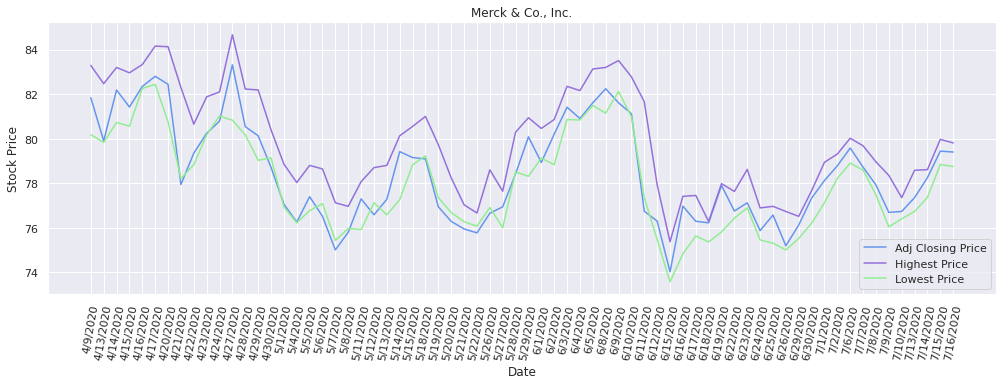

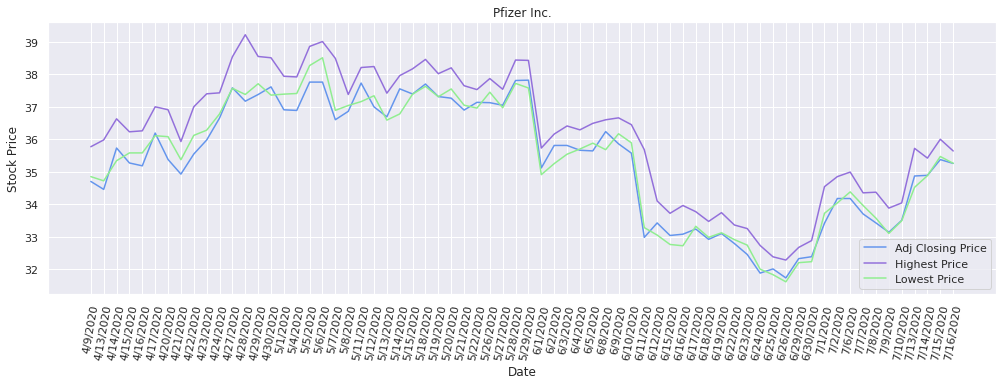



**********************************************************************************************************************************
                                                      Category -  E-commerce
**********************************************************************************************************************************


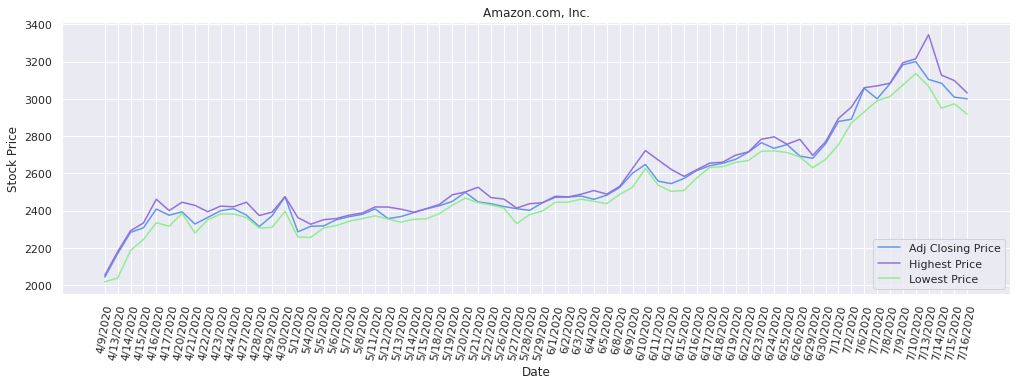



**********************************************************************************************************************************
                                                      Category -  Entertainment
**********************************************************************************************************************************


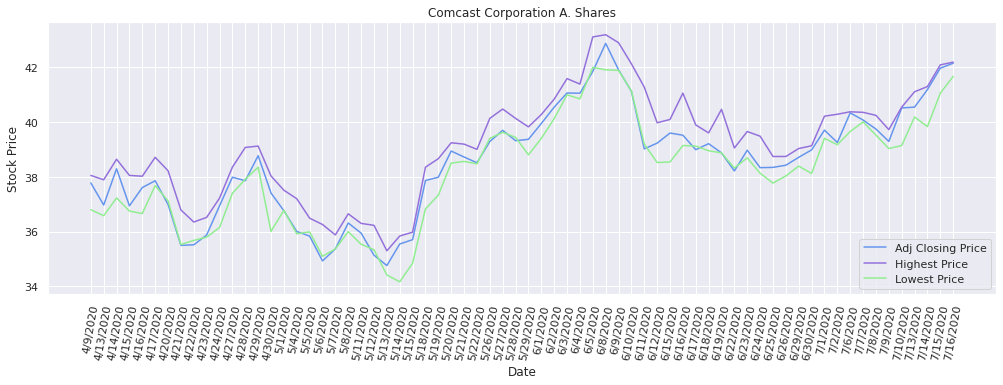

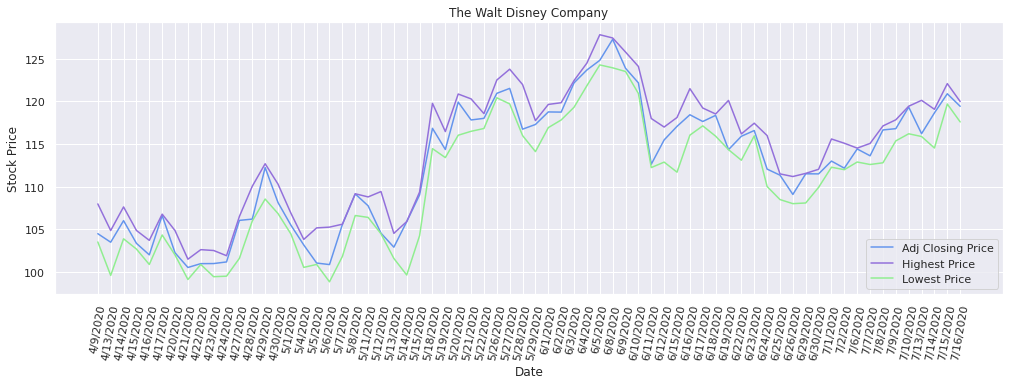



**********************************************************************************************************************************
                                                      Category -  Financial
**********************************************************************************************************************************


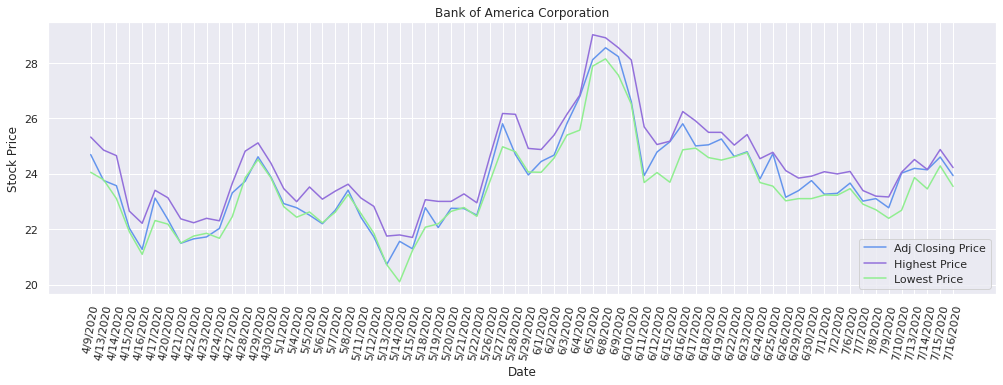

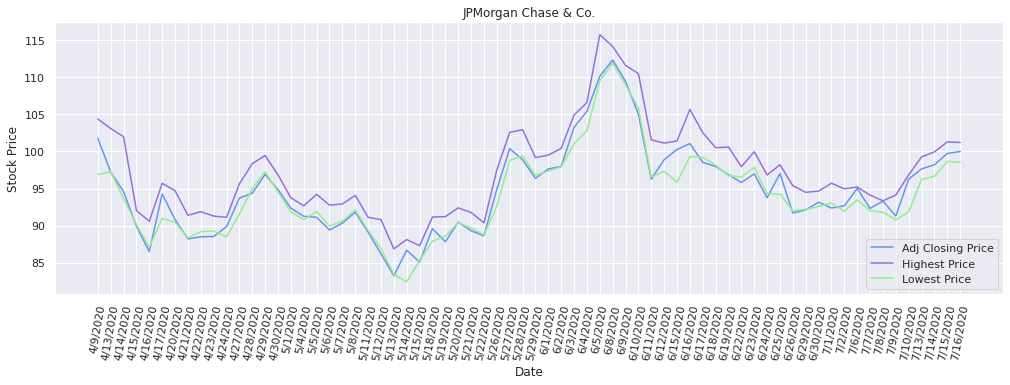

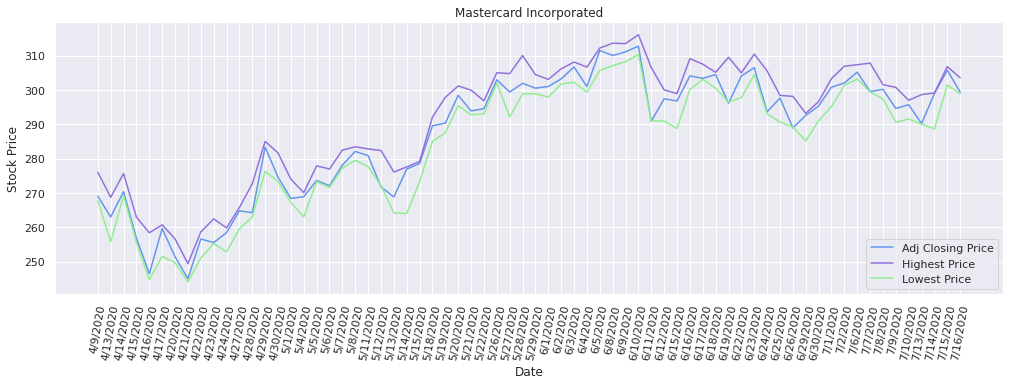

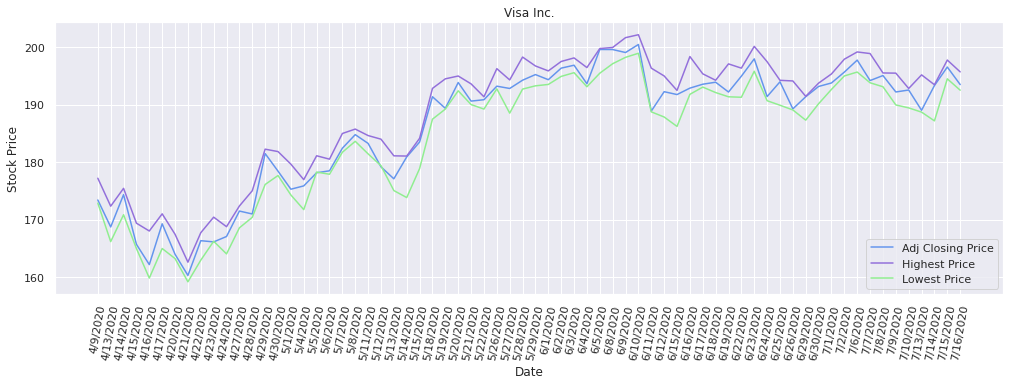



**********************************************************************************************************************************
                                                      Category -  Health Care Plans
**********************************************************************************************************************************


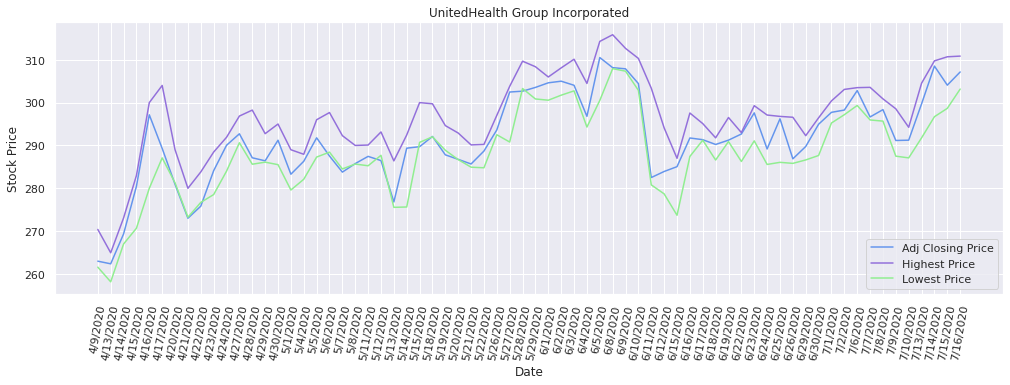



**********************************************************************************************************************************
                                                      Category -  Home Improvement Stores
**********************************************************************************************************************************


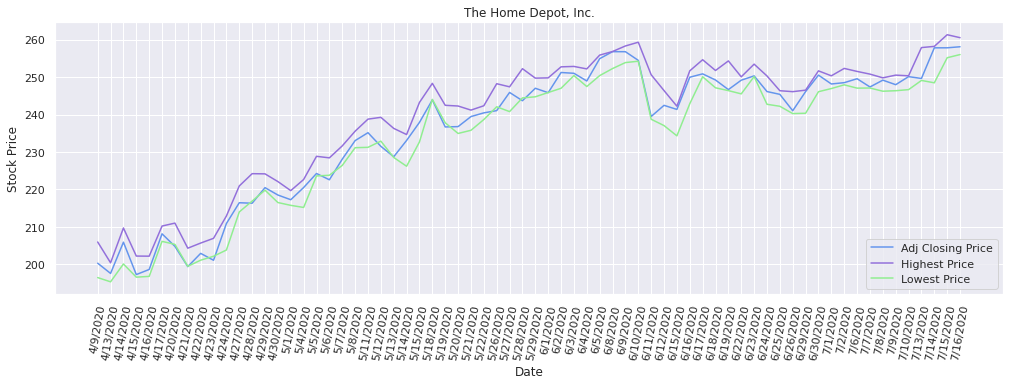



**********************************************************************************************************************************
                                                      Category -  Internet Information Providers
**********************************************************************************************************************************


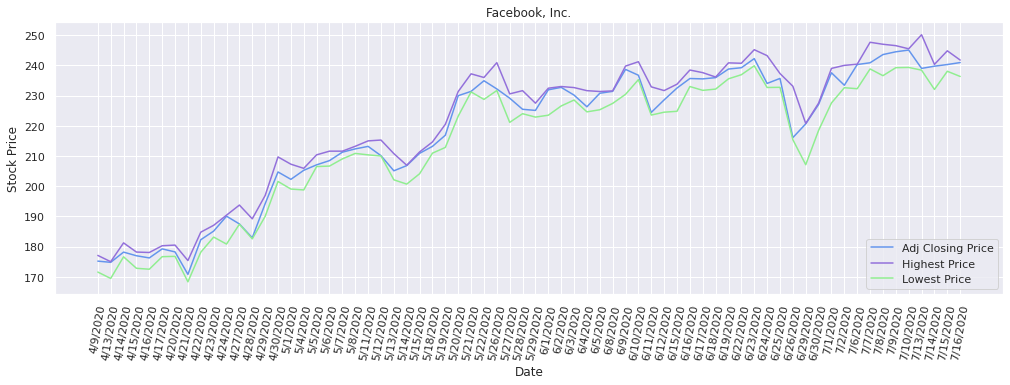

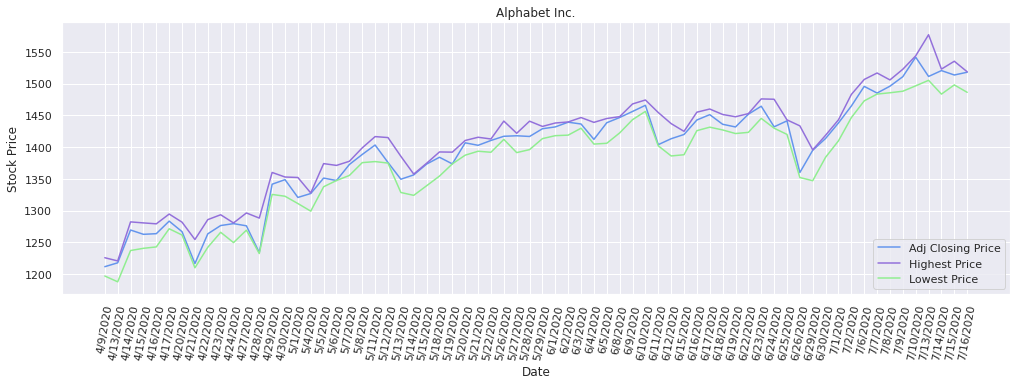



**********************************************************************************************************************************
                                                      Category -  Major Integrated Oil & Gas
**********************************************************************************************************************************


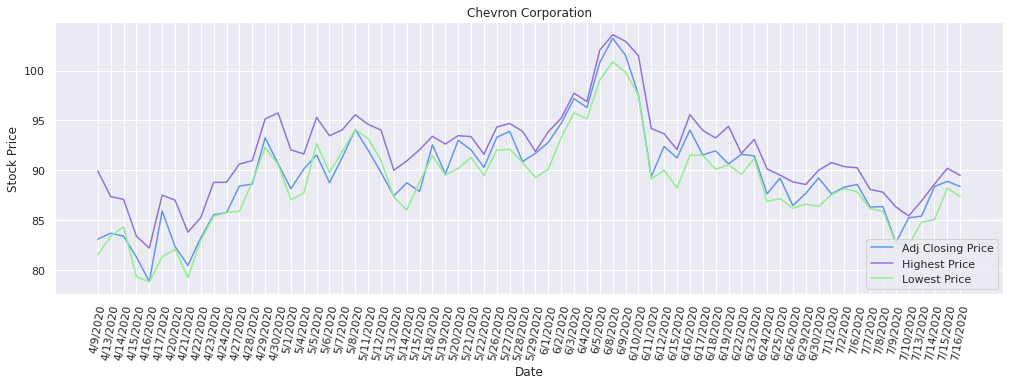

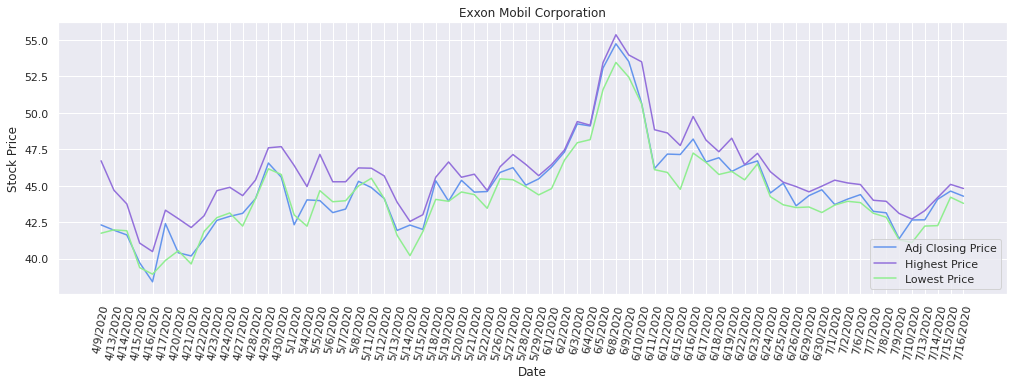



**********************************************************************************************************************************
                                                      Category -  Other
**********************************************************************************************************************************


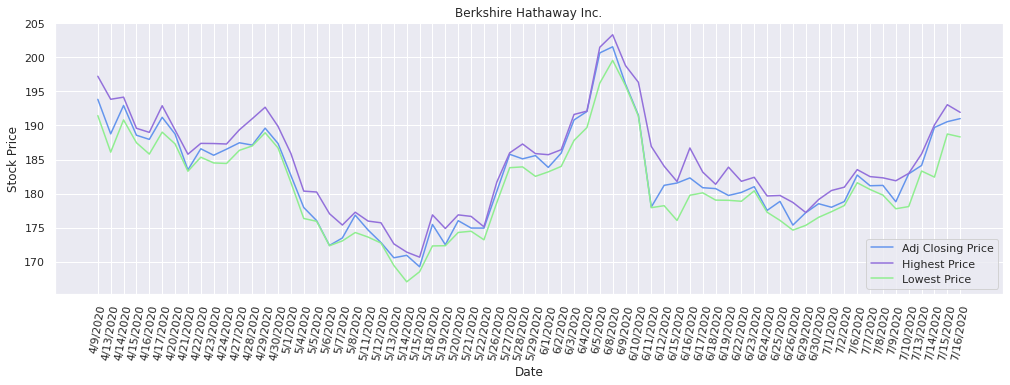



**********************************************************************************************************************************
                                                      Category -  Personal Products
**********************************************************************************************************************************


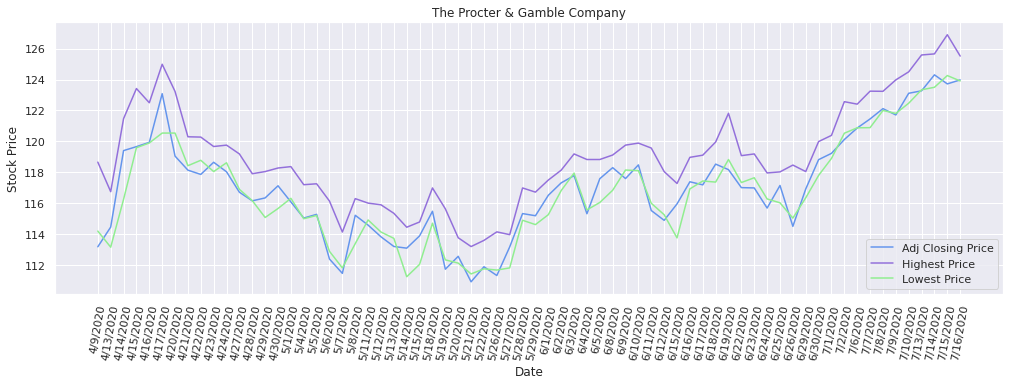



**********************************************************************************************************************************
                                                      Category -  Technology
**********************************************************************************************************************************


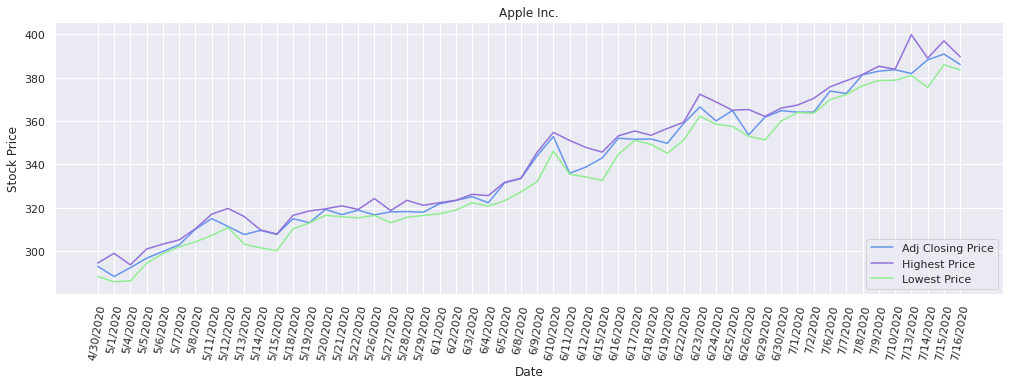

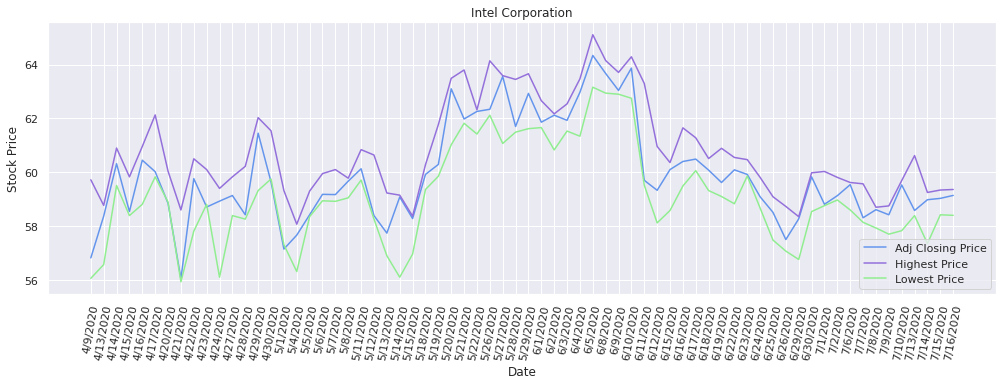

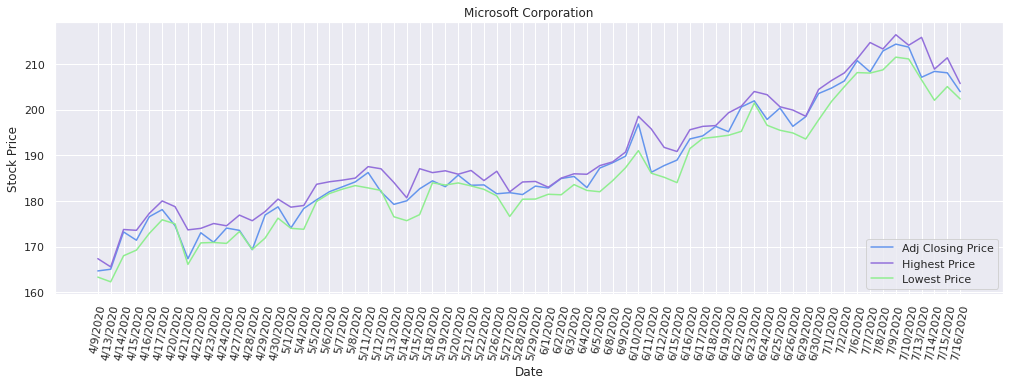



**********************************************************************************************************************************
                                                      Category -  Telecom Services
**********************************************************************************************************************************


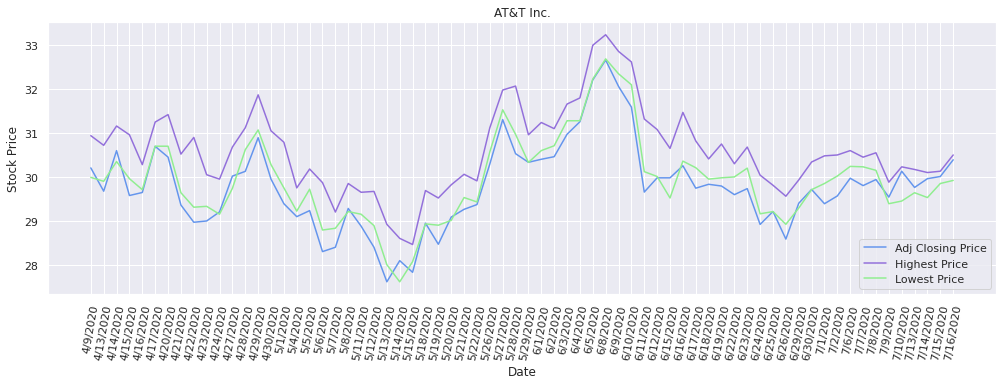

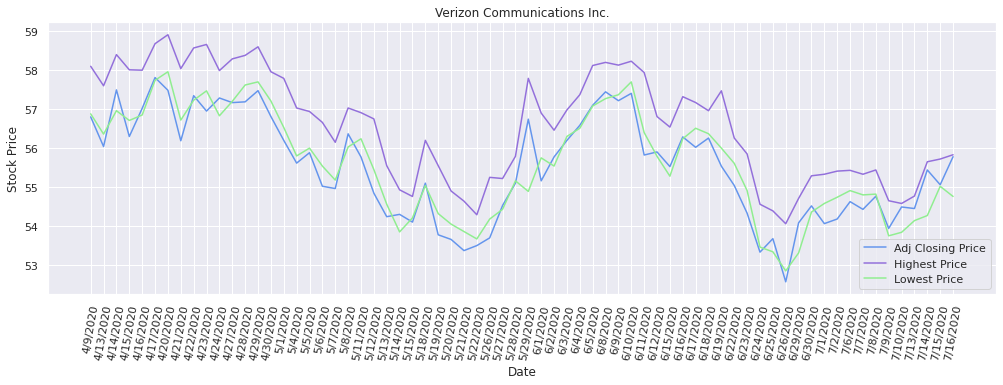

In [14]:
#Now, we look at the stock charts for the companites in each category
#There are some similarlities in movements among the same category
plot_stock_categories(stock_data, categories)

# Twitter Data

In [15]:
#Reading twitter_labeled data
twitter_labeled = pd.read_csv('tweets_labelled_09042020_16072020.csv', sep=';').set_index('id')
print(twitter_labeled.head(5))

twitter_labeled.shape


                       created_at  ... sentiment
id                                 ...          
77522   2020-04-15 01:03:46+00:00  ...  positive
661634  2020-06-25 06:20:06+00:00  ...  negative
413231  2020-06-04 15:41:45+00:00  ...  positive
760262  2020-07-03 19:39:35+00:00  ...  positive
830153  2020-07-09 14:39:14+00:00  ...  positive

[5 rows x 3 columns]


(5000, 3)

In [16]:
#Reading twitter_unlabeled data
twitter_unlabeled = pd.read_csv('tweets_remaining_09042020_16072020.csv', sep=';').set_index('id')
print(twitter_unlabeled.head(5))

twitter_unlabeled.shape

                   created_at                                          full_text
id                                                                              
1   2020-04-09 23:59:51+00:00  @KennyDegu very very little volume. With $10T ...
2   2020-04-09 23:58:55+00:00  #ES_F achieved Target 2780 closing above 50% #...
3   2020-04-09 23:58:52+00:00  RT @KimbleCharting: Silver/Gold indicator crea...
4   2020-04-09 23:58:27+00:00  @Issaquahfunds Hedged our $MSFT position into ...
5   2020-04-09 23:57:59+00:00  RT @zipillinois: 3 Surprisingly Controversial ...


(923673, 2)

In [17]:
#Now, we are going to take a look at the twitter data
#First 3 Tweets in the labeled dataset
for i in range(3):
    pprint(twitter_labeled.iat[i,1])

('RT @RobertBeadles: Yo💥\n'
 'Enter to WIN 1,000 Monarch Tokens✅\n'
 '\n'
 'US Stock Market Crashes &amp; what we can LEARN from them PT3!\n'
 '\n'
 'RETWEET, WATCH video…')
('#SriLanka surcharge on fuel removed!\n'
 '⛽📉\n'
 'The surcharge of Rs.26 imposed on diesel and petrol has been revoked with '
 'effect from midnight on June 23 says Power, Energy and Transport Minister '
 'Mahinda. Amaraweera -Adaderana-\n'
 '\n'
 '#lka #FuelPrices #taxes #economy #stocks #StockMarket')
('Net issuance increases to fund fiscal programs &gt; yields spike higher &gt; '
 'risk off: #stocks and #EMFX correct lower &gt; #Fed comes in with #YCC &gt; '
 'stocks to new all time highs with 20% unemployment and -25% GDP. Fin.')


## Investigate the Tweets

In [18]:
#The code in this cell is modified from https://www.kaggle.com/wordcards/stock-market-tweets-wordcloud
ticker_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)', flags=re.IGNORECASE)
ht_pattern = re.compile(r'#\w+', flags=re.IGNORECASE)
ticker_dic = collections.defaultdict(int)
ht_dic = collections.defaultdict(int)

#for text in twitter_labeled['text']:
def plot_word(data,field,type):
  for i, row in data.iterrows():
    text = data.loc[i,field]

    for word in text.split():
        word = word.upper()
        if ticker_pattern.fullmatch(word) is not None:
            ticker_dic[word[1:]] += 1
            
        word = word.lower()
        if ht_pattern.fullmatch(word) is not None:
            ht_dic[word] += 1
  ticker_df = pd.DataFrame.from_dict(
      ticker_dic, orient='index').rename(columns={0:'count'})\
      .sort_values('count', ascending=False).head(20)
      
  ht_df = pd.DataFrame.from_dict(
      ht_dic, orient='index').rename(columns={0:'count'})\
      .sort_values('count', ascending=False).head(20)

  fig, ax = plt.subplots(1, 2, figsize=(12,8))
  plt.suptitle('Frequent Tickers and Hashtags for '+ type, fontsize=16)
  plt.subplots_adjust(wspace=0.4)

  sns.barplot(x=ticker_df['count'], y=ticker_df.index, orient='h', ax=ax[0])
  ax[0].set_title('Top 20 Tickers')

  sns.barplot(x=ht_df['count'], y=ht_df.index, orient='h', ax=ax[1])
  ax[1].set_title('Top 20 HashTags')

  plt.show()


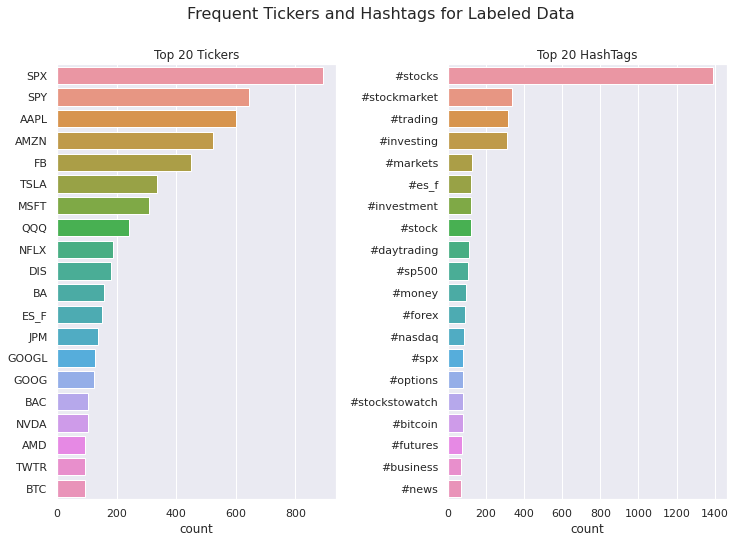

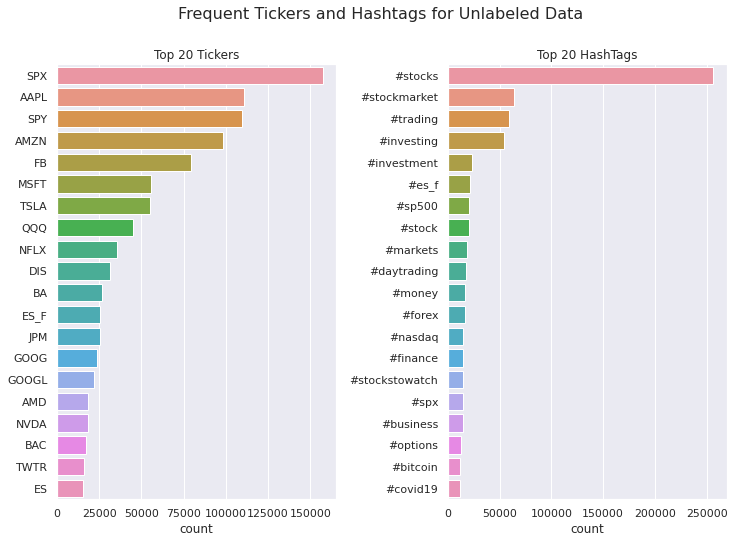

In [19]:
plot_word(twitter_labeled,'text',"Labeled Data")
plot_word(twitter_unlabeled,'full_text', "Unlabeled Data")

## Preprocess the Tweets

In [20]:
##############################################################################################
###This code is necessary ONLY IF we are serarating the tweets into each indivisual tickers###
##############################################################################################

#Create a new dataframe with columns for each stock symbol.

#If the tweet contains the following ticker symbols, the column for the ticker symbol is 1, otherwise 0.
#$MSFT, $AAPL, $AMZN, $FB, $BRK.B, $GOOG, $JNJ, $JPM, $V, $PG, $MA, $INTC $UNH, $BAC, $T, $HD, $XOM, $DIS, $VZ, $KO, $MRK, $CMCSA, $CVX, $PEP, $PFE

#It coniders ticker symbol only, and not the words that are related.  
#For example, a tweet has a word "Amazon" but not "$AMZN", the column "AMZN" will stay 0.

def create_df(data,field):
  new_df = data.copy()
  for symbol in tickers.keys():
    new_df[symbol] = 0

  for i, row in data.iterrows():
    text = data.loc[i,field]
    if "$BRK.B" in text:
      sp_char =  [",","?",":",";","'","-","!"]
    else:
      sp_char =  [",",".","?",":",";","'","-","!"]
    for char in sp_char:
      text = text.replace(char,' ')
      
    for word in text.split():
        word = word.upper()
        if word == '$GOOGL':
          new_df.loc[i,'GOOG'] = 1
        for symbol in tickers.keys():
          t = '$' + symbol
          if t == word:
            new_df.loc[i,symbol] = 1
  return new_df

In [21]:
#new dataframe for labeled dataset and create .csv file
new_twitter_labeled = create_df(twitter_labeled,"text")
new_twitter_labeled.to_csv("new_labeled.csv")

In [22]:
#new dataframe for unlabeled dataset and create .csv file
#It takes about >50 minutes to run.  There is a zip file containing new_unlabeled.csv in Github

#new_twitter_unlabeled = create_df(twitter_unlabeled,"full_text")
#new_twitter_unlabeled.to_csv("new_unlabeled.csv")

In [23]:
#new_twitter_unlabeled.head()

In [24]:
#!wget https://github.com/jfritsche1/cs247/raw/main/Data/new_unlabeled.zip -O new_unlabeled.zip
#unzip new_unlabeled.zip
#new_twitter_unlabeled = pd.read_csv('new_unlabeled.csv').set_index('id')
#new_twitter_unlabeled

In [25]:
#The code in this cell is modified from https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

def text_preprocessing(d,field):
  data = d.copy()
  data['text2'] = data[field]
  for i, row in data.iterrows():
      #$DIS is considered as plural of DI after removing '$'
      #So, replace $DIS with $DISNEY
      data.loc[i,'text2'] = data.loc[i,'text2'].replace("$DIS","$DISNEY")
      data.loc[i,'text2'] = p.clean(data.loc[i,'text2'])
  
  def preprocess_data(data):
  #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
    
    def lemmatize_text(text):
      return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    def remove_punctuation(words):
      new_words = []
      for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        if new_word != '':
            new_words.append(new_word)
      return new_words
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

  pre_tweets = preprocess_data(data['text2'])
  data['text2'] = pre_tweets
  stop_words = set(stopwords.words('english'))
  data['text2'] = data['text2'].apply(lambda x: [item for item in x if item not in stop_words])

  for i, row in data.iterrows():
    data.loc[i,'text2'] = ' '.join(data.loc[i,'text2'])

  return data


In [26]:
#Preprocessing the labeled data
#processed_labeled = text_preprocessing(twitter_labeled,'text')
processed_labeled = text_preprocessing(new_twitter_labeled,'text')
processed_labeled.to_csv("processed_labeled.csv")

# Vader Sentiment Analysis

In [27]:
#Sentiment Analysis using Vader
analyzer = SentimentIntensityAnalyzer()

In [28]:
#The Compound score is a metric that is scaled between -1 and +1
#-1 being most negative score and +1 being most positive score

def vader_sentiment(df):
  scores = []
  # Declare variables for scores
  compound_list = []
  positive_list = []
  negative_list = []
  neutral_list = []
  text = np.array(df['text2'])
  for i in range(text.shape[0]):
      compound = analyzer.polarity_scores(text[i])["compound"]
      pos = analyzer.polarity_scores(text[i])["pos"]
      neu = analyzer.polarity_scores(text[i])["neu"]
      neg = analyzer.polarity_scores(text[i])["neg"]
      
      scores.append({"Compound": compound,
                        "Positive": pos,
                        "Negative": neg,
                        "Neutral": neu
                    })
  sentiments_score = pd.DataFrame.from_dict(scores)
  twitter_sentiments_score = pd.concat([df.reset_index(drop=True),sentiments_score.reset_index(drop=True)], axis=1)

  return twitter_sentiments_score


In [29]:
#Vader sentiment analysis for labeled dataset
twitter_labeled_sentiments_score = vader_sentiment(processed_labeled)
twitter_labeled_sentiments_score.head()

,created_at,text,sentiment,AAPL,AMZN,BAC,BRK.B,CMCSA,CVX,DIS,FB,GOOG,HD,INTC,JNJ,JPM,KO,MA,MRK,MSFT,PEP,PFE,PG,T,UNH,V,VZ,XOM,text2,Compound,Positive,Negative,Neutral
0,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yoenter win monarch tokensus stock market cras...,0.2732,0.230,0.164,0.606
1,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,surcharge fuel removed surcharge r imposed die...,0.4939,0.189,0.055,0.756
2,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,net issuance increase fund fiscal program yiel...,-0.5994,0.090,0.282,0.627
3,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,much amazons traffic served fastly help u find...,0.3818,0.196,0.080,0.725
4,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,amd ryzen desktop cpu looking great track launch,0.6249,0.369,0.000,0.631


In [30]:
#Check the accuracy of the sentiment (before grouping by date)
with_ground_truth = twitter_labeled_sentiments_score[~twitter_labeled_sentiments_score['sentiment'].isnull()]

with_ground_truth['Trend'] = ['positive' if x>0.05 else 'negative' if x<0.05 else 'neutral' for x in with_ground_truth['Compound']]

pcnt_correct = (len(with_ground_truth[with_ground_truth["Trend"]==with_ground_truth["sentiment"]])/len(with_ground_truth))*100
pcnt_incorrect = (len(with_ground_truth[with_ground_truth["Trend"]!=with_ground_truth["sentiment"]])/len(with_ground_truth))*100
print("Percent Correctly Labeled: ", round(pcnt_correct),"%")
print("Percent NOT Correctly Labeled: ", round(pcnt_incorrect),"%")

Percent Correctly Labeled:  51 %
Percent NOT Correctly Labeled:  49 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Group Twitter Sentiment by Date & Ticker

In [31]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%m/%d/%Y").dt.date

In [32]:
temp = twitter_labeled_sentiments_score.copy()
# Add a label column with just the date
temp['Date'] = pd.to_datetime(temp['created_at'], format="%Y-%m-%d").dt.date
grouped_tweets = temp.groupby('Date')
tweet_growth_days = grouped_tweets.sum()

In [33]:
overallScores = []
for ticker, tickVal in tickers.items():
  
  # Get stock data only for this ticker.
  tweet_df = temp[temp[ticker] > 0]
  stk_df = stock_data[(stock_data['Ticker'] == ticker)]
  
  # Get the date range for this ticker data.
  temp_tweet_dates = pd.date_range(tweet_df['Date'][:].min(), tweet_df['Date'][:].max(), freq="D", normalize=True)
  temp_ticker_dates = pd.date_range(stk_df['Date'][:].min(), stk_df['Date'][:].max(), freq="D", normalize=True)
  valid_dates = temp_tweet_dates.union(temp_ticker_dates)

  # Get the metrics for each day.
  for date in valid_dates:

    # Mask to get the stock info for the ticker and correct day.
    tweet_df = temp[(temp['Date'] == date.date()) & (temp[ticker] > 0)]
    stk_df = stock_data[(stock_data['Ticker'] == ticker) & (stock_data['Date'] == date.date())]
    
    if ((len(tweet_df) > 0) and (len(stk_df) > 0)):
      labels = tweet_df["sentiment"].value_counts(dropna=True)
      if (len(labels) > 0):
        # Initialize a structure to store the info for this entry.
        scores = {}

        pos_score = tweet_df['Positive'].mean()
        neg_score = tweet_df['Negative'].mean()
        neu_score = tweet_df['Neutral'].mean()
        cmp_score = tweet_df['Compound'].mean()

        # scores = {'Positive': pos_score,
        #     'Negative': neg_score,
        #     'Neutral': neu_score}
        # # Order here matters. We can't run max on strings.
        # scores['Daily_Trend'] = max(scores,key=scores.get)
        
        # When using the compound score it correctly labels the daily trend 52% of the time
        # versus using the max of the positive, negative, and neutral scores which only gets
        # 30% correct.
        if (cmp_score > 0.05):
          scores['Daily_Trend'] = 'positive'
        elif (cmp_score < -0.05):
          scores['Daily_Trend'] = 'negative'
        else:
          scores['Daily_Trend'] = 'neutral'

        scores['Compound'] = cmp_score
        scores['Ticker'] = ticker
        scores['Date'] = date.date()

        scores['Labels'] = labels.idxmax()

        # Stock Data Set
        scores['High'] = stk_df['High'].item()
        scores['Low'] = stk_df['Low'].item()
        scores['Close'] = stk_df['Close'].item()
        scores['Adj Close'] = stk_df['Adj Close'].item()
        scores['Volume'] = stk_df['Volume'].item()
        scores['plus_di'] = stk_df['plus_di'].item()
        scores['minus_di'] = stk_df['minus_di'].item()
        scores['adx'] = stk_df['adx'].item()
        
        overallScores.append(scores)
    # End of ticker loop
  # End of date loop

In [34]:
daily_sentiment_per_ticker = pd.DataFrame(overallScores, columns=['Adj Close', 'Close', 'Compound', 'Daily_Trend','Date','High','Labels','Low', 'Negative', 'Neutral', 'Positive', 'Ticker','Volume','adx','minus_di','plus_di'])
daily_sentiment_per_ticker = daily_sentiment_per_ticker[['Date','Ticker','Daily_Trend','Compound', 'Negative', 'Neutral', 'Positive','Adj Close', 'Close', 'High','Low','Volume','adx','minus_di','plus_di','Labels']]

In [35]:
#One Hot Encoding
#daily_sentiment_per_ticker_ohc = pd.concat([daily_sentiment_per_ticker, pd.get_dummies(daily_sentiment_per_ticker['Ticker'])], axis=1)
#daily_sentiment_per_ticker_ohc = daily_sentiment_per_ticker_ohc.drop(['Ticker'], axis=1)
#daily_sentiment_per_ticker = daily_sentiment_per_ticker_ohc.copy()

In [36]:
pcnt_correct = (len(daily_sentiment_per_ticker[daily_sentiment_per_ticker["Daily_Trend"]==daily_sentiment_per_ticker["Labels"]])/len(daily_sentiment_per_ticker))*100
pcnt_incorrect = (len(daily_sentiment_per_ticker[daily_sentiment_per_ticker["Daily_Trend"]!=daily_sentiment_per_ticker["Labels"]])/len(daily_sentiment_per_ticker))*100
print("Percent Correctly Labeled: ", round(pcnt_correct),"%")
print("Percent NOT Correctly Labeled: ", round(pcnt_incorrect),"%")

Percent Correctly Labeled:  51 %
Percent NOT Correctly Labeled:  49 %


In [37]:
#AdjClose_Diff is the price difference from the previous day
#AdjClose_shifted is Adjusted Closing Price shifted down by one day
daily_sentiment_per_ticker['AdjClose_Diff'] = daily_sentiment_per_ticker.groupby('Ticker')['Adj Close'].diff(1)

daily_sentiment_per_ticker['AdjClose_Diff_shifted'] = daily_sentiment_per_ticker.groupby('Ticker')['AdjClose_Diff'].shift(-1)
daily_sentiment_per_ticker['AdjClose_shifted'] = daily_sentiment_per_ticker.groupby(['Ticker'])['Adj Close'].shift(1)
daily_sentiment_per_ticker['Trend'] = [1 if x>0 else 0 for x in daily_sentiment_per_ticker['AdjClose_Diff_shifted']]


In [38]:
daily_sentiment_per_ticker

,Date,Ticker,Daily_Trend,Compound,Negative,Neutral,Positive,Adj Close,Close,High,Low,Volume,adx,minus_di,plus_di,Labels,AdjClose_Diff,AdjClose_Diff_shifted,AdjClose_shifted,Trend
0,2020-05-04,AAPL,neutral,0.014214,NaN,NaN,NaN,292.368561,293.160004,293.690002,286.320007,33392000,31.282323,14.903707,30.021964,positive,NaN,4.388122,NaN,1
1,2020-05-05,AAPL,positive,0.199175,NaN,NaN,NaN,296.756683,297.559998,301.000000,294.459991,36937800,32.179223,13.254079,35.453551,neutral,4.388122,6.163300,292.368561,1
2,2020-05-07,AAPL,positive,0.190633,NaN,NaN,NaN,302.919983,303.739990,305.170013,301.970001,28803800,38.003587,11.396203,35.272884,negative,6.163300,7.210022,296.756683,1
3,2020-05-08,AAPL,positive,0.192478,NaN,NaN,NaN,310.130005,310.130005,310.350006,304.290009,33512000,40.402636,10.281724,37.834016,neutral,7.210022,8.119995,302.919983,1
4,2020-05-28,AAPL,positive,0.221167,NaN,NaN,NaN,318.250000,318.250000,323.440002,315.630005,33390200,44.420994,13.092857,34.549684,negative,8.119995,-0.309998,310.130005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2020-05-05,XOM,neutral,-0.008500,NaN,NaN,NaN,43.977310,44.830002,47.150002,44.660000,29276200,36.445853,30.291186,23.768443,neutral,2.648643,5.262692,41.328667,1
364,2020-06-03,XOM,neutral,0.000000,NaN,NaN,NaN,49.240002,49.240002,49.400002,47.950001,23418000,15.947696,23.660605,36.459719,negative,5.262692,5.500000,43.977310,1
365,2020-06-08,XOM,positive,0.263350,NaN,NaN,NaN,54.740002,54.740002,55.360001,53.459999,33579400,18.527375,18.489815,51.318003,negative,5.500000,-10.020001,49.240002,0
366,2020-06-30,XOM,positive,0.607200,NaN,NaN,NaN,44.720001,44.720001,44.970001,43.160000,22153600,12.843868,29.921056,22.611790,positive,-10.020001,-2.060001,54.740002,0


In [39]:
daily_sentiment_per_ticker = daily_sentiment_per_ticker.dropna(subset=['AdjClose_Diff','AdjClose_Diff_shifted','AdjClose_shifted','Trend'])


In [40]:
# pd.date_range(daily_sentiment_per_ticker['Date'][:].min(), daily_sentiment_per_ticker['Date'][:].max(), freq="D", normalize=True)
# len(daily_sentiment_per_ticker)
# Trying to calculate the cross-correlation between the Adj Close and the sentiment Compound.
xcor = {
    'AClose_Compound': sm.tsa.stattools.ccf(daily_sentiment_per_ticker['Adj Close'],daily_sentiment_per_ticker['Compound']),
    'AClose_Pos': sm.tsa.stattools.ccf(daily_sentiment_per_ticker['Adj Close'],daily_sentiment_per_ticker['Positive']),
    'AClose_Neg': sm.tsa.stattools.ccf(daily_sentiment_per_ticker['Adj Close'],daily_sentiment_per_ticker['Negative']),
    'Pos_Vol': sm.tsa.stattools.ccf(daily_sentiment_per_ticker['Positive'],daily_sentiment_per_ticker['Volume']),
    'Sentiment_dAClose': sm.tsa.stattools.ccf(daily_sentiment_per_ticker['Compound'],daily_sentiment_per_ticker['AdjClose_Diff'])
}

## Stock Price Prediction

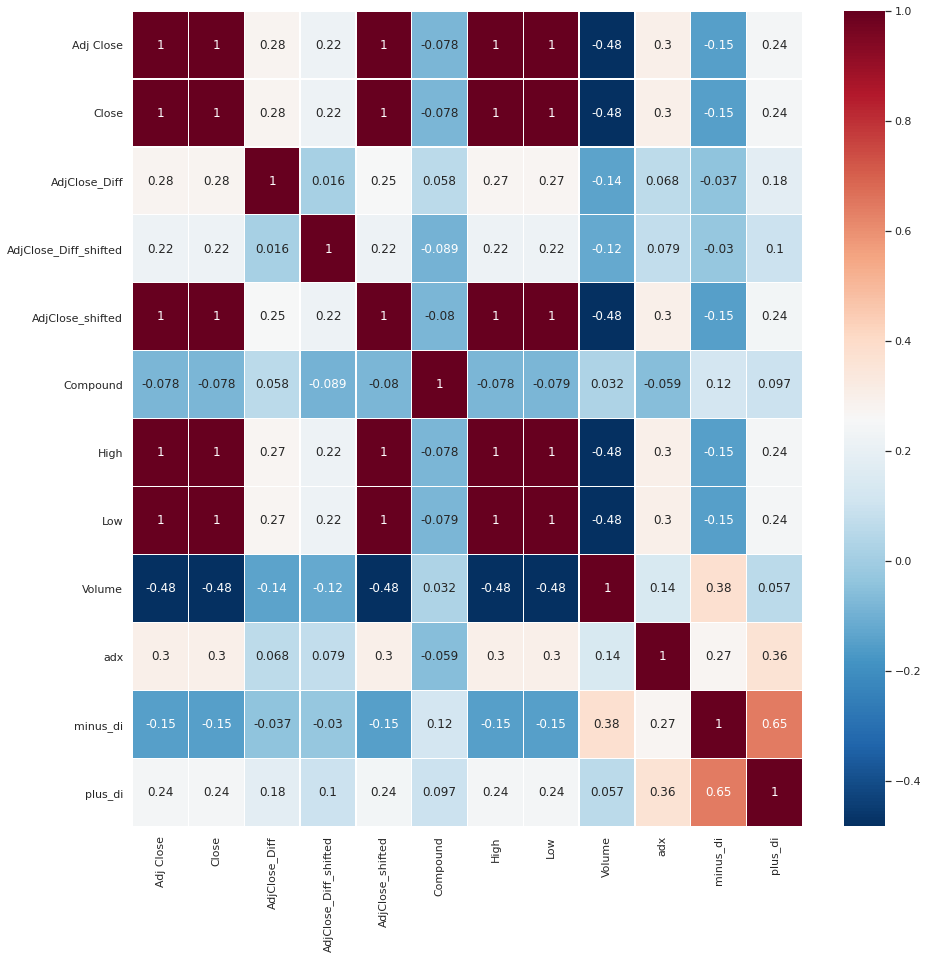

In [41]:
daily_sentiment_per_ticker_numerical = daily_sentiment_per_ticker[['Adj Close', 'Close','AdjClose_Diff','AdjClose_Diff_shifted','AdjClose_shifted','Compound','High','Low','Volume','adx','minus_di','plus_di']]
sCorr = daily_sentiment_per_ticker_numerical.corr(method='pearson')

plt.figure(figsize=(15,15))
sns.heatmap(sCorr,
            xticklabels=sCorr.columns,
            yticklabels=sCorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [58]:
#Logistic Regression to predict if the trend of the stock for the next day can be predicted
train_X, test_X, train_y, test_y = train_test_split(daily_sentiment_per_ticker[['Compound', 'Volume','adx','minus_di','plus_di']],daily_sentiment_per_ticker["Trend"], test_size=0.3)

linClf = LogisticRegression(max_iter=2000).fit(train_X, train_y)
pred_y = linClf.predict(test_X)

# print the evaluation results
print(classification_report(pred_y, test_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.79        96

    accuracy                           0.66        96
   macro avg       0.50      0.33      0.40        96
weighted avg       1.00      0.66      0.79        96



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
#Predict Stock Price using Random Forest

X_rf = daily_sentiment_per_ticker[['Compound', 'Adj Close','Volume','adx','minus_di','plus_di']]
y_rf = daily_sentiment_per_ticker['Adj Close']

from sklearn.ensemble import RandomForestRegressor
scorer = make_scorer(mean_squared_error, squared=False)
#scorer = 'neg_root_mean_squared_error'

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
max_features = [int(x) for x in np.linspace(1, 6, num = 1)]
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
rf = RandomForestRegressor(random_state=42)
rf_gs = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 10, verbose=False, n_jobs = -1, scoring = scorer, return_train_score=True)
rf_gs.fit(X_rf, y_rf)

rf_res1 = pd.DataFrame(rf_gs.cv_results_)
rf_res1 = rf_res1.drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params','split0_test_score',
                'split1_test_score','split2_test_score','split3_test_score','split4_test_score',
                'split5_test_score','split6_test_score','split7_test_score','split8_test_score','split9_test_score','split0_train_score',
                'split1_train_score','split2_train_score','split3_train_score','split4_train_score',
                'split5_train_score','split6_train_score','split7_train_score','split8_train_score','split9_train_score','rank_test_score'],axis=1)
rf_result1 = rf_res1.sort_values(by=['mean_test_score'],ascending=True).reset_index(drop=True)
rf_result1.head(50)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,13,1,80,235.811299,196.148650,67.401810,4.795512
1,None,1,80,238.752493,202.964153,66.649418,2.653748
2,17,1,80,238.844991,203.554430,66.770932,2.643992
3,20,1,80,239.465321,202.544364,66.782696,2.793529
4,15,1,80,240.675763,206.210286,65.822544,3.494399
5,9,1,80,240.857083,203.606191,72.150583,3.878076
6,11,1,180,243.820063,199.015543,66.689461,4.667442
7,20,1,40,244.779138,194.721072,69.839566,6.972197
8,11,1,80,245.175946,201.751489,68.402058,5.858163
9,13,1,60,245.285940,201.135453,69.625345,6.994109


Out of Bag error is:  0.17513930561063373


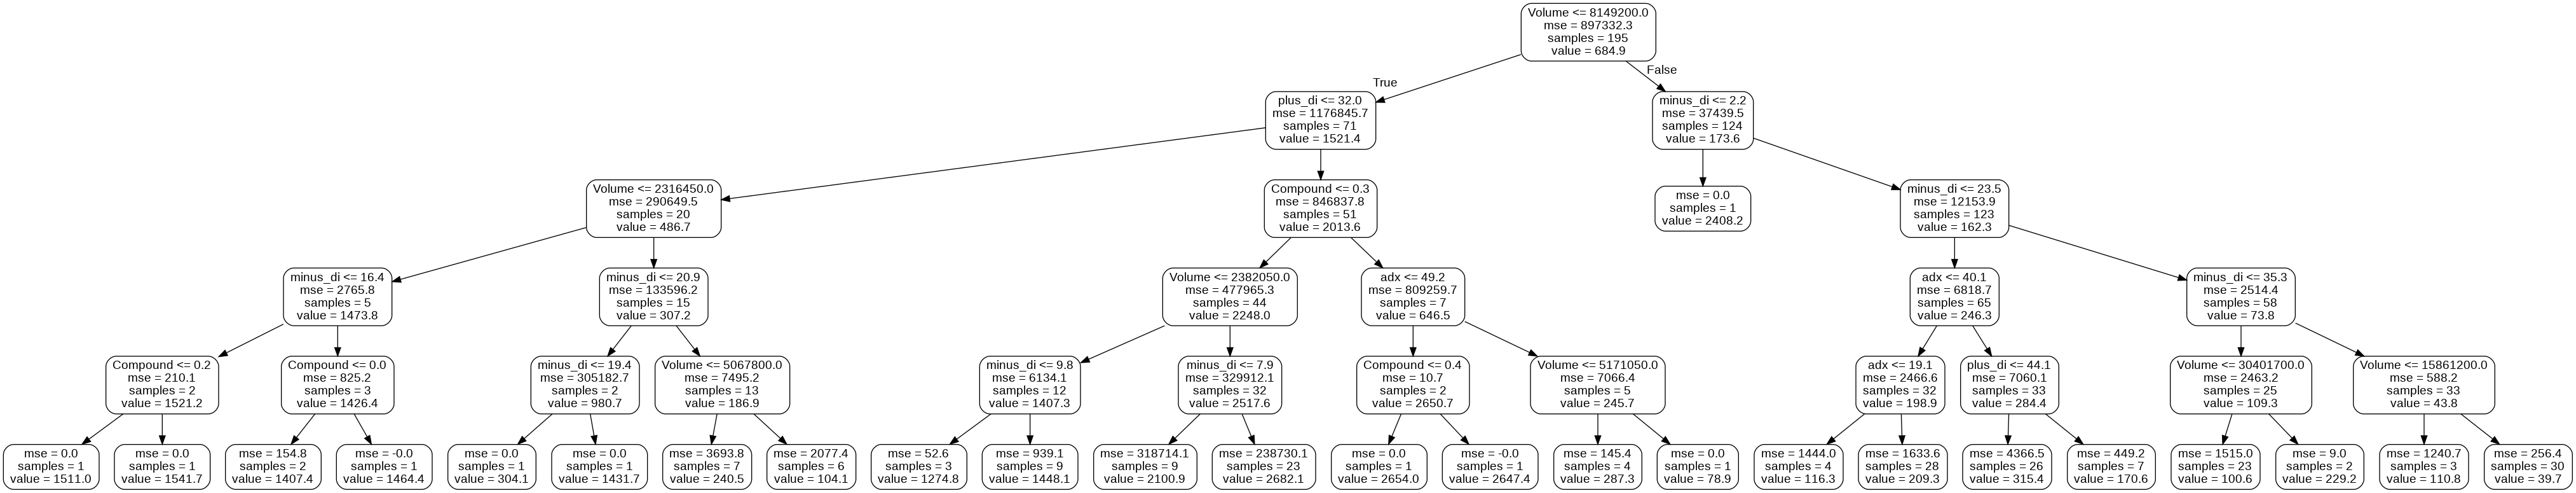

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

rf_viz = RandomForestRegressor(n_estimators=40, max_features=5, max_depth=5, random_state=42, oob_score=True)
rf_viz.fit(X_rf, y_rf)
oob_error = 1 - rf_viz.oob_score_
print('Out of Bag error is: ', oob_error)

tree = rf_viz.estimators_[1]
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_rf.columns, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('tree.dot')
Image(graph.create_png())